# Avant propos
   Nous devons comprendre ce qui affecte si le cours des actions de GS(par exemple) va monter ou descendre.Par conséquent, nous devons incorporer autant d'informations (décrivant le stock sous différents aspects et angles) que possible. (Nous utiliserons les données quotidiennes 1.585 jours pour former les différents algorithmes (70% des données dont nous disposons) et prédire les 680 prochains jours (données de test). Ensuite, nous comparerons les résultats prévus avec des données de test (hold-out).
   ayant tant de fonctionnalités, nous devons effectuer quelques étapes importantes:
###### 1- Effectuer des contrôles statistiques de la «qualité» des données. Si les données que nous créons sont défectueuses, peu importe la sophistication de nos algorithmes, les résultats ne seront pas positifs. Les vérifications consistent à s'assurer que les données ne souffrent pas d'hétéroskédasticité, de multicolinéarité ou de corrélation série.
###### 2-Créer l'importance des fonctionnalités. Si une caractéristique (par exemple un autre stock ou un indicateur technique) n'a aucun pouvoir explicatif sur le stock que nous voulons prédire, il n'est pas nécessaire pour nous de l'utiliser dans la formation des réseaux neuronaux. Nous utiliserons XGBoost (eXtreme Gradient Boosting), un type d'algorithmes de régression d'arbre boosté.

   Comme dernière étape de notre préparation des données, nous créerons également des portefeuilles propres en utilisant l'analyse en composantes principales (ACP) afin de réduire la dimensionnalité des fonctionnalités créées à partir des encodeurs automatiques.




In [2]:
import matplotlib
from jedi.api.refactoring import inline
from utils import *

import time
import numpy as np
import pandas as pd

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
# %matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

import warnings

import bert

from collections import deque

In [4]:
warnings.filterwarnings("ignore")

context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)


In [5]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m/%d')

In [6]:
dataset_ex_df = pd.read_csv('C:/Users/ABIR/Downloads/stock-trading-system-master (2)/stock-trading-system-master/data/ge.csv')


In [7]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))


There are 14058 number of days in the dataset.


In [8]:
dataset_ex_df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0
1,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0
2,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0
3,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0
4,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0


###### Visualisons le stock des neuf dernières années. La ligne verticale en pointillés représente la séparation entre les données de formation et de test.


<Figure size 432x288 with 0 Axes>

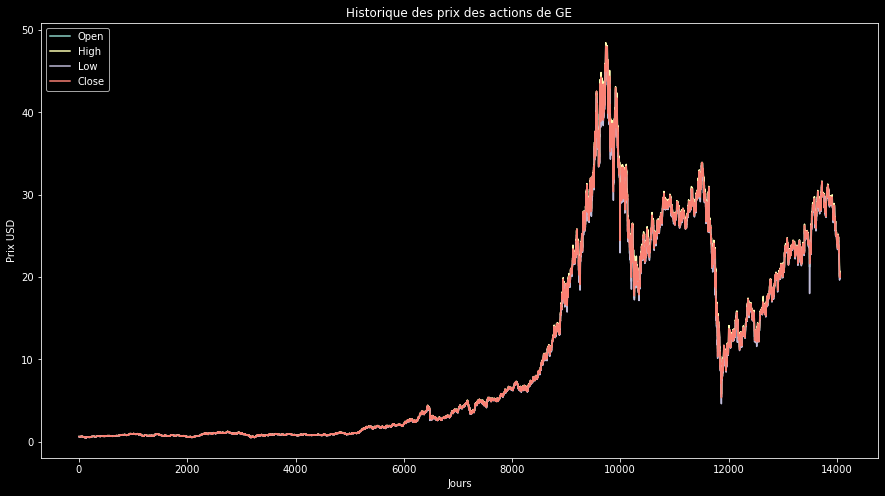

In [14]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use('dark_background')

plt.figure()
plt.figure(figsize=(15,8))
plt.plot(dataset_ex_df["Open"])
plt.plot(dataset_ex_df["High"])
plt.plot(dataset_ex_df["Low"])
plt.plot(dataset_ex_df["Close"])
plt.title('Historique des prix des actions de GE')
plt.ylabel('Prix USD')
plt.xlabel('Jours')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

In [15]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days,dataset_ex_df.shape[0]-num_training_days))

Number of training days: 9840. Number of test days: 4218.


In [74]:
import math

In [33]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()

    # Create MACD
#     dataset['26ema'] = pd.ewma(dataset['price'], span=26)
    dataset['26ema'] = dataset['Close'].ewm(span = 26).mean()
    #dataset['12ema'] = pd.ewma(dataset['price'], span=12)
    dataset['12ema'] = dataset['Close'].ewm(span = 12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(20).std()
    
    dataset['upper_band'] = dataset['ma21'] + 2*(dataset['Close'].rolling(20).std())
    dataset['lower_band'] = dataset['ma21'] - 2*(dataset['Close'].rolling(20).std())

    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

    # Create Momentum
    dataset['momentum'] = dataset['Close']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])

    return dataset

In [34]:
dataset_TI_df = get_technical_indicators(dataset_ex_df[['Close']])
dataset_TI_df = dataset_TI_df.drop(range(20))

##### Nous avons donc les indicateurs techniques (y compris MACD, bandes de Bollinger, etc.) pour chaque jour de bourse. Nous avons au total 12 indicateurs techniques.

In [35]:
dataset_TI_df.head(50)


,Close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
20,0.6037,0.598000,0.599586,0.598459,0.598155,-0.000304,0.007984,0.615554,0.583617,0.601087,-0.3963,NaN
21,0.6277,0.601429,0.599948,0.601113,0.602819,0.001705,0.009158,0.618264,0.581632,0.618829,-0.3723,NaN
22,0.6201,0.606043,0.599948,0.602808,0.605536,0.002727,0.009900,0.619748,0.580147,0.619676,-0.3799,NaN
23,0.6201,0.608386,0.600324,0.604329,0.607818,0.003489,0.010883,0.622091,0.578557,0.619959,-0.3799,NaN
24,0.6122,0.610743,0.601110,0.605012,0.608502,0.003491,0.011119,0.623347,0.578872,0.614786,-0.3878,NaN
25,0.6201,0.614229,0.602271,0.606304,0.610310,0.004006,0.011782,0.625835,0.578708,0.618329,-0.3799,NaN
26,0.6277,0.618800,0.603795,0.608116,0.613015,0.004899,0.012914,0.629623,0.577968,0.624576,-0.3723,NaN
27,0.6277,0.622229,0.605319,0.609757,0.615296,0.005539,0.013760,0.632839,0.577799,0.626659,-0.3723,NaN
28,0.6277,0.622229,0.606843,0.611246,0.617219,0.005974,0.013905,0.634652,0.579034,0.627353,-0.3723,NaN
29,0.6277,0.623314,0.608743,0.612599,0.618842,0.006243,0.014276,0.637294,0.580192,0.627584,-0.3723,NaN


In [36]:
dataset_TI_df.notna().sum()

Close           14038
ma7             14038
ma21            14038
26ema           14038
12ema           14038
MACD            14038
20sd            14038
upper_band      14038
lower_band      14038
ema             14038
momentum        14038
log_momentum     9703
dtype: int64

In [37]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

##### on va visualiser les 400 derniers jours de ces indicateurs.



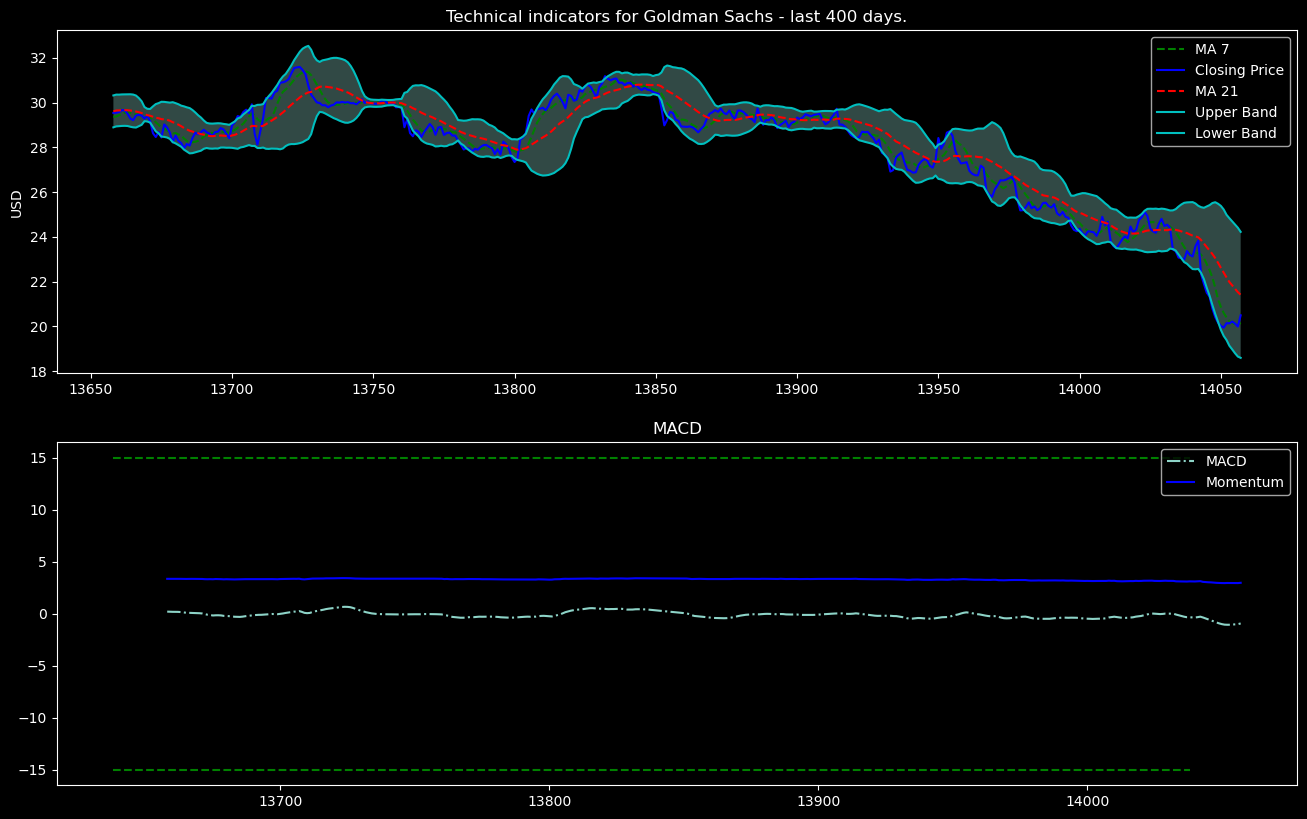

In [38]:
plot_technical_indicators(dataset_TI_df, 400)

# analyse fondamentale
Pour l'analyse fondamentale, nous effectuerons une analyse des sentiments sur toutes les nouvelles quotidiennes sur GS. En utilisant sigmoïde à la fin, le résultat sera compris entre 0 et 1. Plus le score est proche de 0 - plus les informations sont négatives (plus près de 1 indique un sentiment positif). Pour chaque jour, nous créerons le score quotidien moyen (sous forme de nombre compris entre 0 et 1) et l'ajouterons en tant que fonctionnalité.


In [39]:
data_FT = dataset_ex_df[['Date', 'Close']]


 Les transformées de Fourier prennent une fonction et créent une série d'ondes sinusoïdales (avec différentes amplitudes et trames). Lorsqu'elles sont combinées, ces ondes sinusoïdales se rapprochent de la fonction d'origine. Mathématiquement parlant, les transformations ressemblent à ceci:

$$ G (f) = \ int _ {- \ infty} ^ \ infty g (t) e ^ {- i 2 \ pi f t} dt $$

       Nous utiliserons les transformées de Fourier pour extraire les tendances globales et locales du stock GS, et aussi pour le débruiter un peu. Voyons donc comment cela fonctionne.

In [40]:
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

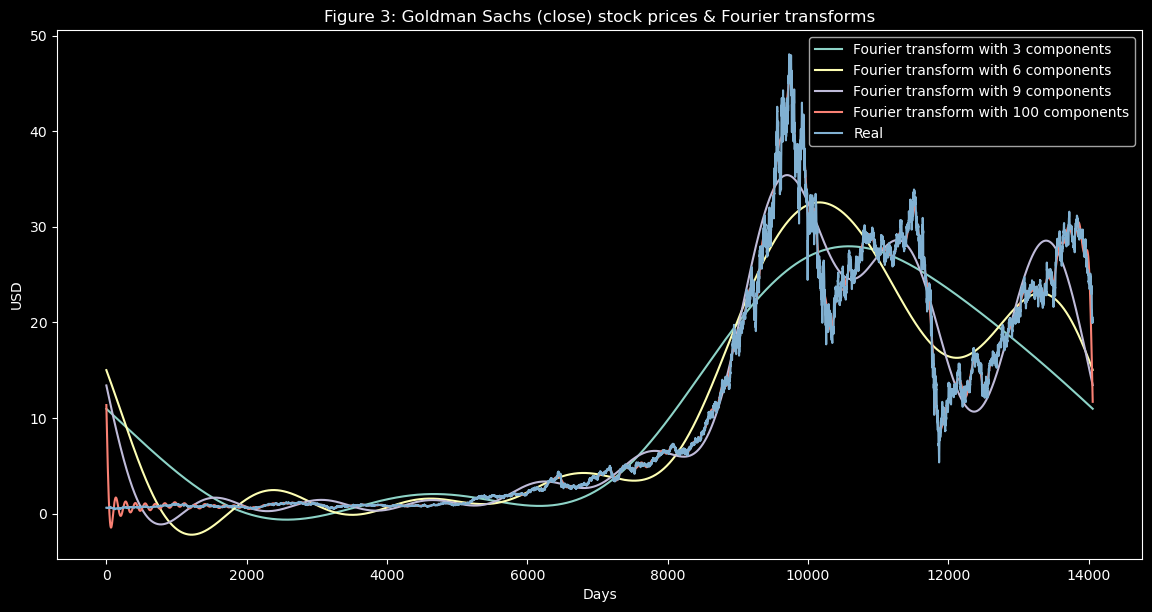

In [41]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

Comme vous le voyez sur la figure 3, plus nous utilisons de transformée de Fourier, plus la fonction d'approximation est proche du prix réel de l'action (la transformation de 100 composants est presque identique à la fonction d'origine - les lignes rouge et violette se chevauchent presque). 
Nous utilisons des transformées de Fourier dans le but d'extraire des tendances à long et à court terme, nous utiliserons donc les transformées à 3, 6 et 9 composants. Vous pouvez en déduire que la transformation à 3 composants sert de tendance à long terme.


Une autre technique utilisée pour débruiter les données est les ondelettes d'appel. Les ondelettes et la transformée de Fourier ont donné des résultats similaires, nous n'utiliserons donc que des transformées de Fourier.


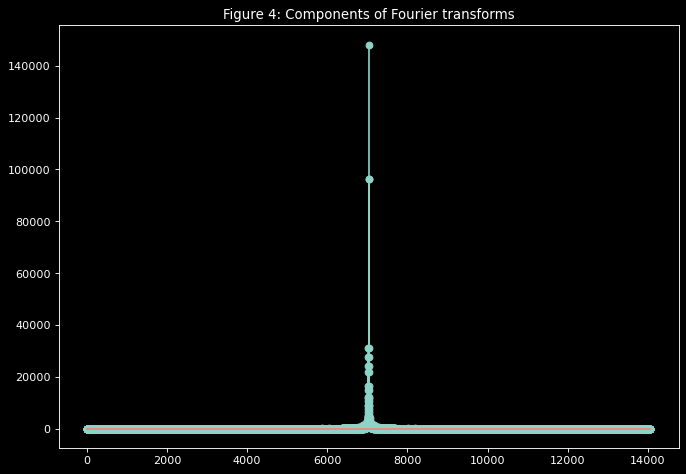

In [42]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

# ARIMA

ARIMA est une technique de prédiction des données de séries chronologiques. Nous allons montrer comment l'utiliser, et cependant ARIMA ne nous servira pas de prédiction finale, nous l'utiliserons comme technique pour débrouiller un peu le stock et pour (éventuellement) extraire de nouveaux motifs ou fonctionnalités.


In [43]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                14057
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1815.684
Method:                       css-mle   S.D. of innovations              0.275
Date:                Sat, 23 May 2020   AIC                           3645.369
Time:                        12:47:34   BIC                           3698.225
Sample:                             1   HQIC                          3662.962
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0014      0.002      0.693      0.488      -0.003       0.005
ar.L1.D.Close    -0.0241      0.008     -2.867      0.004      -0.041      -0.008
ar.L2.D.Close    -0.0553      0.008     

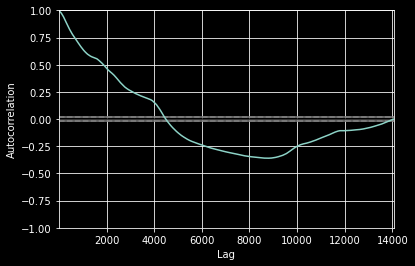

<Figure size 800x560 with 0 Axes>

In [44]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [45]:
from tqdm import tqdm
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in tqdm(range(len(test))):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

100%|██████████████████████████████████████████████████████████████████████████████| 4780/4780 [38:53<00:00,  2.05it/s]


In [46]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 0.210


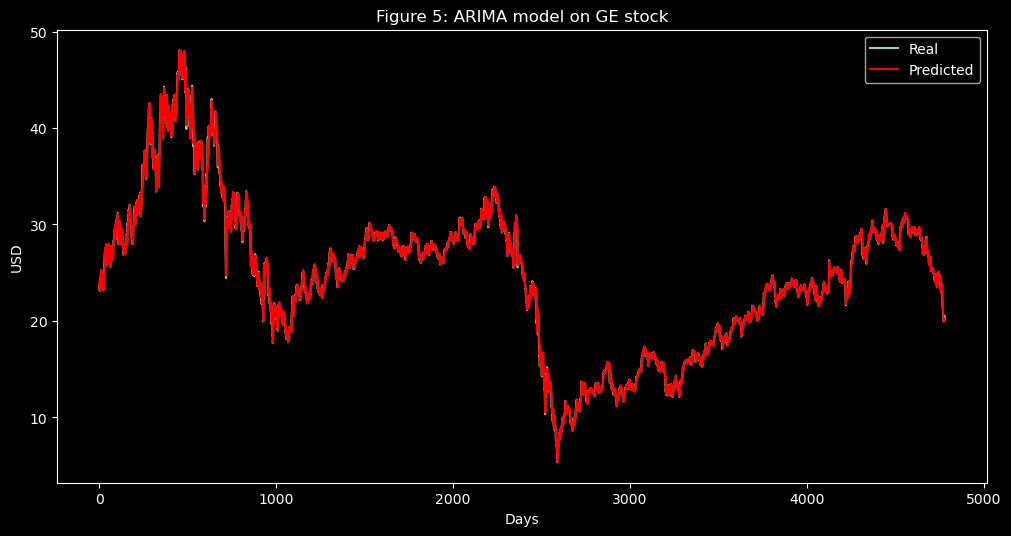

In [47]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GE stock')
plt.legend()
plt.show()


Comme nous pouvons le voir sur la figure 5, ARIMA donne une très bonne approximation du cours réel des actions. Nous utiliserons le prix prévu via ARIMA en tant que fonctionnalité d'entrée dans le LSTM car, comme nous l'avons mentionné précédemment, nous voulons capturer autant de fonctionnalités et de modèles concernant Goldman Sachs que possible. Nous allons tester MSE (erreur quadratique moyenne) de 10.151, ce qui en soi n'est pas un mauvais résultat (étant donné que nous avons beaucoup de données de test), mais nous ne l'utiliserons que comme fonctionnalité dans le LSTM.


# Contrôles statistiques


Il est très important de s'assurer que les données sont de bonne qualité pour nos modèles. Afin de nous assurer que nos données sont appropriées, nous effectuerons quelques vérifications simples afin de nous assurer que les résultats que nous obtenons et observons sont bien réels, plutôt que compromis, car la distribution des données sous-jacentes souffre d'erreurs fondamentales.


## Hétéroscédasticité, multicollinéarité, corrélation série


L'hétéroscédasticité conditionnelle se produit lorsque les termes d'erreur (la différence entre une valeur prédite par une régression et la valeur réelle) dépendent des données - par exemple, les termes d'erreur augmentent lorsque le point de données (le long de l'axe des x) augmente.

La multicollinéarité est lorsque les termes d'erreur (également appelés résidus) dépendent les uns des autres.

La corrélation série se produit lorsqu'une donnée (entité) est une formule (ou dépend entièrement) d'une autre entité.



# Ingénierie des fonctionnalités


In [93]:
dataset_total_df= dataset_TI_df

print('Total dataset has {} samples, and {} features.'.format(dataset_total_df.shape[0], \
                                                              dataset_total_df.shape[1]))

Total dataset has 14038 samples, and 12 features.


### Importance des fonctionnalités avec XGBoost



Avec autant de fonctionnalités, nous devons nous demander si toutes sont vraiment indicatives de la direction que prendra le stock GS. Par exemple, nous avons inclus les taux LIBOR libellés en USD dans l'ensemble de données parce que nous pensons que des changements dans le LIBOR pourraient indiquer des changements dans l'économie, ce qui, à son tour, pourrait indiquer des changements dans le comportement des stocks du GS. Mais nous devons tester. Il existe de nombreuses façons de tester l'importance des fonctionnalités, mais celle que nous appliquerons utilise XGBoost, car elle donne l'un des meilleurs résultats en termes de problèmes de classification et de régression.

Étant donné que l'ensemble de données d'entités est assez volumineux, aux fins de présentation ici, nous n'utiliserons que les indicateurs techniques. Pendant le test d'importance des fonctionnalités réelles, toutes les fonctionnalités sélectionnées se sont révélées quelque peu importantes, nous n'exclurons donc rien lors de la formation du GAN.


In [94]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [95]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_TI_df)

In [96]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)


In [97]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

In [98]:
eval_result = regressor.evals_result()


In [99]:
training_rounds = range(len(eval_result['validation_0']['rmse']))



Traçons les erreurs de training et de validation afin d'observer la formation et de vérifier le sur-ajustement (il n'y a pas de sur-ajustement)


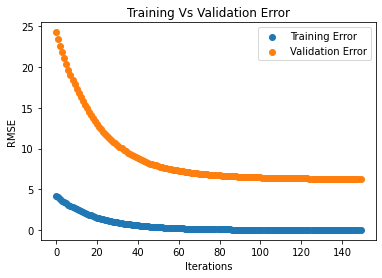

In [100]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

# Extraire des fonctionnalités de haut niveau avec les encodeurs automatiques empilés

### Fonction d'activation - GELU (Gaussian Error)

La cellule ci-dessous montre la logique derrière les mathématiques de GELU. Ce n'est pas l'implémentation réelle en tant que fonction d'activation. J'ai dû implémenter GELU dans MXNet. Si vous suivez le code et changez act_type = 'relu' en act_type = 'gelu' cela ne fonctionnera pas, sauf si vous modifiez l'implémentation de MXNet. Faites une requête pull sur l'ensemble du projet pour accéder à l'implémentation MXNet de GELU.

In [101]:
def gelu(x):
    return 0.5 * x * (1 + math.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * math.pow(x, 3))))
def relu(x):
    return max(x, 0)
def lrelu(x):
    return max(0.01*x, x)

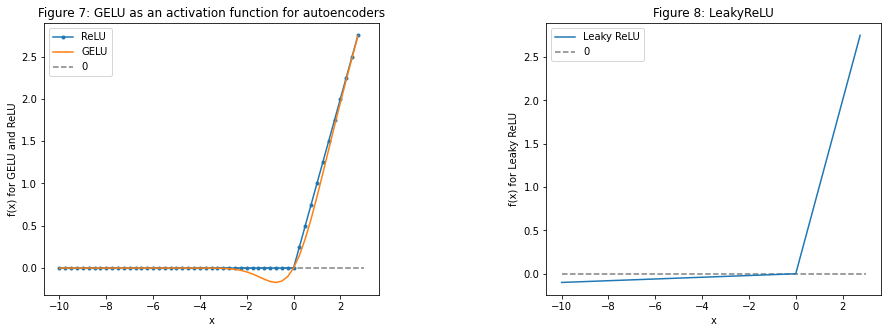

In [102]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=None)

ranges_ = (-10, 3, .25)

plt.subplot(1, 2, 1)
plt.plot([i for i in np.arange(*ranges_)], [relu(i) for i in np.arange(*ranges_)], label='ReLU', marker='.')
plt.plot([i for i in np.arange(*ranges_)], [gelu(i) for i in np.arange(*ranges_)], label='GELU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.title('Figure 7: GELU as an activation function for autoencoders')
plt.ylabel('f(x) for GELU and ReLU')
plt.xlabel('x')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([i for i in np.arange(*ranges_)], [lrelu(i) for i in np.arange(*ranges_)], label='Leaky ReLU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.ylabel('f(x) for Leaky ReLU')
plt.xlabel('x')
plt.title('Figure 8: LeakyReLU')
plt.legend()

plt.show()

In [103]:
batch_size = 64

model_ctx =  mx.cpu()
class VAE(gluon.HybridBlock):
    def __init__(self, n_hidden=400, n_latent=2, n_layers=1, n_output=784, \
                 batch_size=100, act_type='gelu', **kwargs):
        self.soft_zero = 1e-10
        self.n_latent = n_latent
        self.batch_size = batch_size
        self.output = None
        self.mu = None
        super(VAE, self).__init__(**kwargs)
        
        with self.name_scope():
            self.encoder = nn.HybridSequential(prefix='encoder')
            
            for i in range(n_layers):
                self.encoder.add(nn.Dense(n_hidden, activation=act_type))
            self.encoder.add(nn.Dense(n_latent*2, activation=None))

            self.decoder = nn.HybridSequential(prefix='decoder')
            for i in range(n_layers):
                self.decoder.add(nn.Dense(n_hidden, activation=act_type))
            self.decoder.add(nn.Dense(n_output, activation='sigmoid'))

    def hybrid_forward(self, F, x):
        h = self.encoder(x)
        #print(h)
        mu_lv = F.split(h, axis=1, num_outputs=2)
        mu = mu_lv[0]
        lv = mu_lv[1]
        self.mu = mu

        eps = F.random_normal(loc=0, scale=1, shape=(self.batch_size, self.n_latent), ctx=model_ctx)
        z = mu + F.exp(0.5*lv)*eps
        y = self.decoder(z)
        self.output = y

        KL = 0.5*F.sum(1+lv-mu*mu-F.exp(lv),axis=1)
        logloss = F.sum(x*F.log(y+self.soft_zero)+ (1-x)*F.log(1-y+self.soft_zero), axis=1)
        loss = -logloss-KL

        return loss

In [104]:
n_hidden=400 # neurons in each layer
n_latent=2 
n_layers=3 # num of dense layers in encoder and decoder respectively

net = VAE(n_hidden=n_hidden, n_latent=n_latent, n_layers=n_layers, n_output=40, batch_size=batch_size, act_type='relu')

In [105]:
net.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())
net.hybridize()
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': .01})

In [106]:
print(net)


VAE(
  (encoder): HybridSequential(
    (0): Dense(None -> 400, Activation(relu))
    (1): Dense(None -> 400, Activation(relu))
    (2): Dense(None -> 400, Activation(relu))
    (3): Dense(None -> 4, linear)
  )
  (decoder): HybridSequential(
    (0): Dense(None -> 400, Activation(relu))
    (1): Dense(None -> 400, Activation(relu))
    (2): Dense(None -> 400, Activation(relu))
    (3): Dense(None -> 40, Activation(sigmoid))
  )
)


Nous avons donc 3 couches (avec 400 neurones dans chacune) à la fois dans l'encodeur et le décodeur.

In [107]:
vae_added_df = mx.nd.array(dataset_total_df.iloc[:, :-1].values)
print('The shape of the newly created (from the autoencoder) features is {}.'.format(vae_added_df.shape))




The shape of the newly created (from the autoencoder) features is (14038, 11).


# Pourquoi GAN pour la prédiction boursière?


Les Réseaux Génératifs Adversaires (GAN) ont récemment été utilisés principalement pour créer des images, des peintures et des clips vidéo réalistes. Il n'y a pas beaucoup d'applications de GAN utilisées pour prédire les données de séries chronologiques comme dans notre cas. L'idée principale, cependant, devrait être la même: nous voulons prédire les mouvements futurs des stocks. À l'avenir, la structure et le comportement du stock de GS devraient être plus ou moins les mêmes (à moins qu'il ne commence à fonctionner de manière totalement différente ou que l'économie ne change radicalement). Par conséquent, nous voulons «générer» des données pour l'avenir qui auront une distribution similaire (pas absolument la même, bien sûr) que celle que nous avons déjà - les données de trading historiques. Donc, en théorie, cela devrait fonctionner.

Dans notre cas, nous utiliserons LSTM comme générateur de séries temporelles et CNN comme discriminateur.

Comme mentionné précédemment, le générateur est un réseau LSTM, un type de réseau neuronal récurrent (RNN). Les RNN sont utilisés pour les données de séries temporelles car ils gardent une trace de tous les points de données précédents et peuvent capturer des modèles évoluant dans le temps. En raison de leur nature, les RNN souffrent souvent d'un gradient de fuite - c'est-à-dire que les changements que les poids reçoivent pendant l'entraînement deviennent si petits qu'ils ne changent pas, ce qui rend le réseau incapable de converger vers une perte minimale (le problème opposé peut également être observé à certains moments - lorsque les gradients deviennent trop grands. C'est ce qu'on appelle l'explosion du gradient, mais la solution est assez simple - couper les gradients s'ils commencent à dépasser un certain nombre constant, c'est-à-dire l'écrêtage du gradient). Deux modifications s'attaquent à ce problème - Gated Recurrent Unit (GRU) et Long-Short Term Memory (LSTM). Les plus grandes différences entre les deux sont: 1) GRU a 2 portes (mise à jour et réinitialisation) et LSTM en a 4 (mise à jour, entrée, oubli et sortie), 2) LSTM maintient un état de mémoire interne, tandis que GRU n'en a pas, et 3) LSTM applique une non-linéarité (sigmoïde) avant la porte de sortie, contrairement à GRU.

Dans la plupart des cas, LSTM et GRU donnent des résultats similaires en termes de précision, mais GRU est beaucoup moins intensif en calcul, car GRU a beaucoup moins de paramètres entraînables. Les LSTM, cependant, et beaucoup plus utilisés.

Strictement parlant, le calcul derrière la cellule LSTM (les portes) est:

$$g_t = \text{tanh}(X_t W_{xg} + h_{t-1} W_{hg} + b_g),$$

$$i_t = \sigma(X_t W_{xi} + h_{t-1} W_{hi} + b_i),$$

$$f_t = \sigma(X_t W_{xf} + h_{t-1} W_{hf} + b_f),$$

$$o_t = \sigma(X_t W_{xo} + h_{t-1} W_{ho} + b_o),$$

$$c_t = f_t \odot c_{t-1} + i_t \odot g_t,$$

$$h_t = o_t \odot \text{tanh}(c_t),$$


où $ \ odot $ est un opérateur de multiplication par élément et, pour tous $ x = [x_1, x_2, \ ldots, x_k] ^ \ top \ dans R ^ k $, les deux fonctions d'activation :,

$$ \ sigma (x) = \ left [\ frac {1} {1+ \ exp (-x_1)}, \ ldots, \ frac {1} {1+ \ exp (-x_k)}] \ right] ^ \ top, $$

$$ \ text {tanh} (x) = \ left [\ frac {1- \ exp (-2x_1)} {1+ \ exp (-2x_1)}, \ ldots, \ frac {1- \ exp (-2x_k )} {1+ \ exp (-2x_k)} \ right] ^ \ top $$

# Architecutre LSTM


L'architecture LSTM est très simple - une couche LSTM avec 12 unités d'entrée (car nous avons 12 entités dans l'ensemble de données) et 500 unités cachées, et une couche dense avec 1 sortie - le prix pour chaque jour. L'initialiseur est Xavier et nous utiliserons la perte L1 (qui est la perte d'erreur absolue moyenne avec la régularisation L1.

Remarque - Dans le code, vous pouvez voir que nous utilisons Adam (avec un taux d'apprentissage de 0,01) comme optimiseur. Ne faites pas trop attention à cela maintenant - il y a une section spécialement dédiée pour expliquer quels hyperparamètres nous utilisons et comment nous optimisons ces hyperparamètres

In [108]:
gan_num_features = dataset_TI_df.shape[1]
sequence_length = 17

class RNNModel(gluon.Block):
    def __init__(self, num_embed, num_hidden, num_layers, bidirectional=False, \
                 sequence_length=sequence_length, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.num_hidden = num_hidden
        with self.name_scope():
            self.rnn = rnn.LSTM(num_hidden, num_layers, input_size=num_embed, \
                                bidirectional=bidirectional, layout='TNC')
            
            self.decoder = nn.Dense(1, in_units=num_hidden)
    
    def forward(self, inputs, hidden):
        output, hidden = self.rnn(inputs, hidden)
        decoded = self.decoder(output.reshape((-1, self.num_hidden)))
        return decoded, hidden
    
    def begin_state(self, *args, **kwargs):
        return self.rnn.begin_state(*args, **kwargs)
    
lstm_model = RNNModel(num_embed=gan_num_features, num_hidden=500, num_layers=1)
lstm_model.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())
trainer = gluon.Trainer(lstm_model.collect_params(), 'adam', {'learning_rate': .01})
loss = gluon.loss.L1Loss()


In [109]:
print(lstm_model)


RNNModel(
  (rnn): LSTM(12 -> 500, TNC)
  (decoder): Dense(500 -> 1, linear)
)


Comme nous pouvons le voir, l'entrée du LSTM sont les 13 entités (dataset_TI_df.shape [1]) qui entrent ensuite dans 500 neurones dans la couche LSTM, puis transformées en une seule sortie - la valeur du cours de l'action.

La logique derrière le LSTM est la suivante: nous prenons 17 jours (séquence_length) de données (encore une fois, les données étant le cours de l'action GS tous les jours + toutes les autres fonctionnalités de cette journée - actifs corrélés, sentiment, etc.) et essayons de prédire le 18e jour.

Dans un autre article, j'explorerai si une modification de la vanille LSTM serait plus bénéfique, comme:

    -en utilisant la couche LSTM bidirectionnelle - en théorie, un retour en arrière (de la fin de l'ensemble de données vers le début) pourrait en quelque sorte aider le LSTM à comprendre le modèle du mouvement des stocks.
    -en utilisant une architecture RNN empilée - ayant non seulement une couche LSTM mais 2 ou plus. Cependant, cela pourrait être dangereux, car nous pourrions finir par sur-adapter le modèle, car nous n'avons pas beaucoup de données (nous avons seulement 1 585 jours de données).
    -Explorer GRU - comme déjà expliqué, les cellules des GRU sont beaucoup plus simples.
    -Ajout de vecteurs d'attention au RNN.

L'un des hyperparamètres les plus importants est le taux d'apprentissage. La définition du taux d'apprentissage pour presque tous les optimiseurs (tels que SGD, Adam ou RMSProp) est d'une importance cruciale lors de la formation des réseaux de neurones car elle contrôle à la fois la vitesse de convergence et les performances ultimes du réseau. L'une des stratégies de taux d'apprentissage les plus simples consiste à avoir un taux d'apprentissage fixe tout au long du processus de formation. Le choix d'un faible taux d'apprentissage permet à l'optimiseur de trouver de bonnes solutions, mais cela se fait au détriment de la limitation de la vitesse initiale de convergence. La modification du taux d'apprentissage au fil du temps peut surmonter ce compromis.


In [110]:
class TriangularSchedule():
    def __init__(self, min_lr, max_lr, cycle_length, inc_fraction=0.5):     
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        self.inc_fraction = inc_fraction
        
    def __call__(self, iteration):
        if iteration <= self.cycle_length*self.inc_fraction:
            unit_cycle = iteration * 1 / (self.cycle_length * self.inc_fraction)
        elif iteration <= self.cycle_length:
            unit_cycle = (self.cycle_length - iteration) * 1 / (self.cycle_length * (1 - self.inc_fraction))
        else:
            unit_cycle = 0
        adjusted_cycle = (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr
        return adjusted_cycle

class CyclicalSchedule():
    def __init__(self, schedule_class, cycle_length, cycle_length_decay=1, cycle_magnitude_decay=1, **kwargs):
        self.schedule_class = schedule_class
        self.length = cycle_length
        self.length_decay = cycle_length_decay
        self.magnitude_decay = cycle_magnitude_decay
        self.kwargs = kwargs
    
    def __call__(self, iteration):
        cycle_idx = 0
        cycle_length = self.length
        idx = self.length
        while idx <= iteration:
            cycle_length = math.ceil(cycle_length * self.length_decay)
            cycle_idx += 1
            idx += cycle_length
        cycle_offset = iteration - idx + cycle_length
        
        schedule = self.schedule_class(cycle_length=cycle_length, **self.kwargs)
        return schedule(cycle_offset) * self.magnitude_decay**cycle_idx

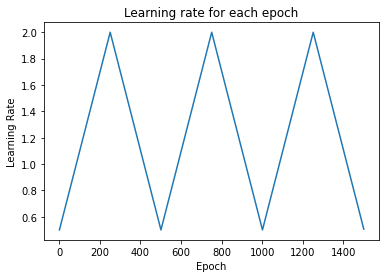

In [111]:
schedule = CyclicalSchedule(TriangularSchedule, min_lr=0.5, max_lr=2, cycle_length=500)
iterations=1500

plt.plot([i+1 for i in range(iterations)],[schedule(i) for i in range(iterations)])
plt.title('Learning rate for each epoch')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()

In [112]:
num_fc = 512

# ... other parts of the GAN

cnn_net = gluon.nn.Sequential()
with net.name_scope():
    
    # Add the 1D Convolutional layers
    cnn_net.add(gluon.nn.Conv1D(32, kernel_size=5, strides=2))
    cnn_net.add(nn.LeakyReLU(0.01))
    cnn_net.add(gluon.nn.Conv1D(64, kernel_size=5, strides=2))
    cnn_net.add(nn.LeakyReLU(0.01))
    cnn_net.add(nn.BatchNorm())
    cnn_net.add(gluon.nn.Conv1D(128, kernel_size=5, strides=2))
    cnn_net.add(nn.LeakyReLU(0.01))
    cnn_net.add(nn.BatchNorm())
    
    # Add the two Fully Connected layers
    cnn_net.add(nn.Dense(220, use_bias=False), nn.BatchNorm(), nn.LeakyReLU(0.01))
    cnn_net.add(nn.Dense(220, use_bias=False), nn.Activation(activation='relu'))
    cnn_net.add(nn.Dense(1))

In [113]:
print(cnn_net)


Sequential(
  (0): Conv1D(None -> 32, kernel_size=(5,), stride=(2,))
  (1): LeakyReLU(0.01)
  (2): Conv1D(None -> 64, kernel_size=(5,), stride=(2,))
  (3): LeakyReLU(0.01)
  (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (5): Conv1D(None -> 128, kernel_size=(5,), stride=(2,))
  (6): LeakyReLU(0.01)
  (7): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (8): Dense(None -> 220, linear)
  (9): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (10): LeakyReLU(0.01)
  (11): Dense(None -> 220, linear)
  (12): Activation(relu)
  (13): Dense(None -> 1, linear)
)


Les hyperparamètres que nous allons suivre et optimiser sont:

    batch_size: taille de lot du LSTM et du CNN
    cnn_lr: le taux d'apprentissage du CNN
    foulées: le nombre de foulées dans le CNN
    lrelu_alpha: l'alpha du LeakyReLU dans le GAN
    batchnorm_momentum: momentum pour la normalisation des lots dans le CNN
    padding: le rembourrage dans le CNN
    kernel_size ': 1: taille du noyau dans le CNN
    abandon: abandon dans le LSTM
    filtres: le nombre initial de filtres
Nous allons faire l'apprentissage de  plus de 200 époques

# Le résultat

# 1-Normalisation des données

Les données ne sont pas normalisées et la plage pour chaque colonne varie, en particulier le volume. La normalisation des données aide l'algorithme à converger, c'est-à-dire à trouver efficacement le minimum local / global.

Nous utiliserons MinMaxScaler de Sci-kit Learn. Mais avant cela, nous devons diviser l'ensemble de données en ensembles de données d'apprentissage(training) et de test. Je vais également convertir le DataFrame en ndarray dans le processus.

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# definir les colonnes qu'on va nourrir à notre modèle d'apprentissage
train_cols = ["Open","High","Low","Close","Volume"]

# nous voulons 80% des données en training et les 20% qui restent pour tester le modèle sur des données qu'il n'a pas encore appris
gs_train, gs_test = train_test_split(dataset_ex_df, train_size=0.8, test_size=0.2, shuffle=False)

# regarder la forme de nos données, leur taille..
print(gs_train.shape)
print(gs_test.shape)

# redimensionnement pour garder les colonnes qui nous interéssent
x = gs_train.loc[:,train_cols].values
xx = gs_test.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(xx)

print(x_train.shape)
print(x_test.shape)

(11246, 7)
(2812, 7)
(11246, 5)
(2812, 5)


In [20]:
batch_size = 20


In [21]:
time_steps = 60


In [17]:
from tqdm import tqdm

def build_timeseries(matrix, y_col_index):
    # y_col_index est l'indice dela colonne qui sera l'output
    '''
     le dernier échantillon permet de prédire la dernière case
     donc le nombre total d'échantillons est len(matrix) - time_steps
    '''
    n = matrix.shape[0] - time_steps
    m = matrix.shape[1]

    x = np.zeros((n, time_steps, m))
    y = np.zeros((n,))
    
    for i in range(n):
        x[i] = matrix[i:time_steps+i]
        y[i] = matrix[time_steps+i, y_col_index]
    print("La taille de la série chronologique est :\nInput : ", x.shape, "\nOutput : ", y.shape)
    return x, y

In [18]:
# coupe l'ensemble d'apprentissage en une taille divisible par le batch_size
def trim_dataset(matrix, batch_size):
    rows_to_drop = matrix.shape[0] % batch_size
    if(rows_to_drop > 0):
        return matrix[:-rows_to_drop] # retire rows_to_drop ligne depuis la fin
    else:
        return matrix

In [22]:
# training set
x_t, y_t = build_timeseries(x_train, 3) # y_col_index=3 car on prédit la colonne prix 'Close'
x_t = trim_dataset(x_t, batch_size)
y_t = trim_dataset(y_t, batch_size)

# validation set and test set
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, batch_size), 2)
y_val, y_test_t = np.split(trim_dataset(y_temp, batch_size), 2)

La taille de la série chronologique est :
Input :  (11186, 60, 5) 
Output :  (11186,)
La taille de la série chronologique est :
Input :  (2752, 60, 5) 
Output :  (2752,)


In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras import optimizers
import keras

learning_rate = 1e-4
optimizer = optimizers.RMSprop(lr=learning_rate)

import tensorflow as tf

Using TensorFlow backend.


In [24]:
model = Sequential([
    LSTM(100, batch_input_shape=(batch_size, time_steps, x_t.shape[2]), stateful=True, kernel_initializer='random_uniform'),
    Dropout(0.5),
    Dense(20,activation='relu'),
    Dense(1,activation='sigmoid')                  
])

model.summary()

model.compile(loss='mean_squared_error', optimizer=optimizer)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (20, 100)                 42400     
_________________________________________________________________
dropout_1 (Dropout)          (20, 100)                 0         
_________________________________________________________________
dense_1 (Dense)              (20, 20)                  2020      
_________________________________________________________________
dense_2 (Dense)              (20, 1)                   21        
Total params: 44,441
Trainable params: 44,441
Non-trainable params: 0
_________________________________________________________________


In [25]:

history = model.fit(
    x_t,
    y_t,
    epochs=100,
    verbose=2,
    batch_size=batch_size,
    shuffle=False,
    validation_data=(trim_dataset(x_val, batch_size), trim_dataset(y_val, batch_size))
)


Train on 11180 samples, validate on 1360 samples
Epoch 1/100
 - 12s - loss: 0.0207 - val_loss: 0.0462
Epoch 2/100
 - 13s - loss: 0.0070 - val_loss: 0.0017
Epoch 3/100
 - 17s - loss: 0.0025 - val_loss: 0.0039
Epoch 4/100
 - 17s - loss: 0.0023 - val_loss: 0.0050
Epoch 5/100
 - 17s - loss: 0.0021 - val_loss: 0.0066
Epoch 6/100
 - 18s - loss: 0.0021 - val_loss: 0.0079
Epoch 7/100
 - 19s - loss: 0.0019 - val_loss: 0.0073
Epoch 8/100
 - 21s - loss: 0.0017 - val_loss: 0.0079
Epoch 9/100
 - 29s - loss: 0.0016 - val_loss: 0.0068
Epoch 10/100
 - 20s - loss: 0.0013 - val_loss: 0.0062
Epoch 11/100
 - 19s - loss: 0.0012 - val_loss: 0.0049
Epoch 12/100
 - 19s - loss: 0.0011 - val_loss: 0.0045
Epoch 13/100
 - 19s - loss: 0.0011 - val_loss: 0.0035
Epoch 14/100
 - 16s - loss: 0.0010 - val_loss: 0.0029
Epoch 15/100
 - 15s - loss: 9.7481e-04 - val_loss: 0.0025
Epoch 16/100
 - 15s - loss: 9.2462e-04 - val_loss: 0.0021
Epoch 17/100
 - 15s - loss: 8.5137e-04 - val_loss: 0.0022
Epoch 18/100
 - 15s - loss: 8.

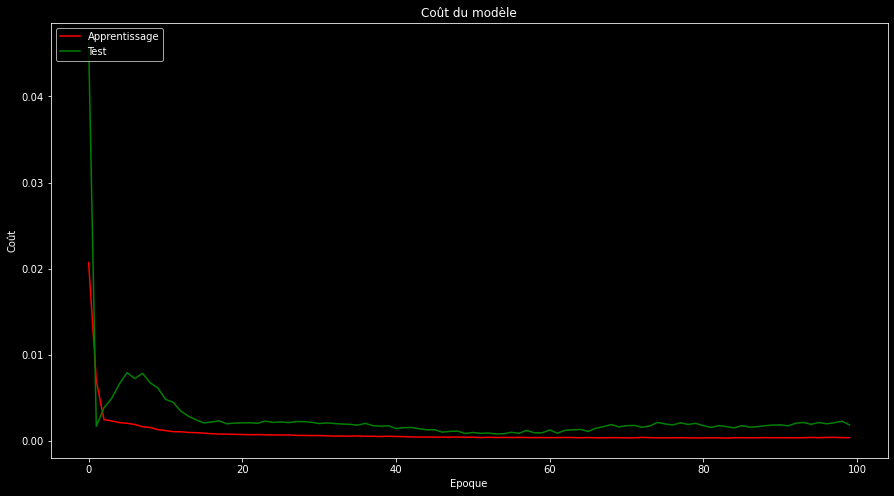

In [26]:
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='green')
plt.title('Coût du modèle')
plt.ylabel('Coût')
plt.xlabel('Epoque')
plt.legend(['Apprentissage', 'Test'], loc='upper left')
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(trim_dataset(x_test_t, batch_size), batch_size=batch_size)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, batch_size)
error = mean_squared_error(y_test_t, y_pred)

print("L'erreur est :", error)

L'erreur est : 0.0005643720268840519


In [28]:
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
error = mean_squared_error(y_test_t_org, y_pred_org)

print("L'erreur réelle est :", error)

L'erreur réelle est : 1.2785702017952931


<Figure size 432x288 with 0 Axes>

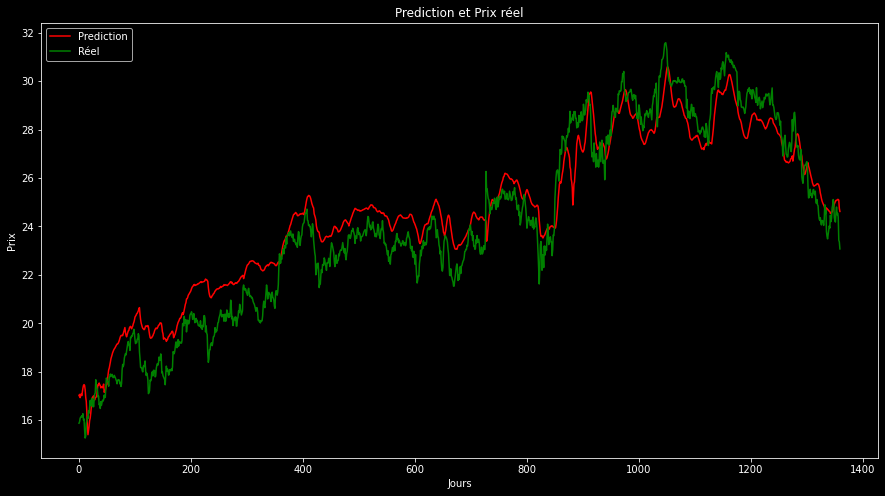

In [29]:
plt.figure()
plt.figure(figsize=(15,8))
plt.plot(y_pred_org, color='red')
plt.plot(y_test_t_org, color='green')
plt.title('Prediction et Prix réel')
plt.ylabel('Prix')
plt.xlabel('Jours')
plt.legend(['Prediction', 'Réel'], loc='upper left')
plt.show()
